In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import audio_tagging_utils as utils
import matplotlib.pyplot as plt

In [2]:
# Importing Keras and other pre-processing libraries
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras.backend as K
import gc

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4540619990922840171
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1422504755
locality {
  bus_id: 1
  links {
  }
}
incarnation: 122021403973958967
physical_device_desc: "device: 0, name: GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


Now we will transform each .wav file from the training and test sets to a corresponding spectogram.


In [ ]:
utils.create_images_no_prepro('train', 'train_no_preprocessing')

In [ ]:
utils.create_images_no_prepro('test', 'test_no_preprocessing')

Now It is time to build our predictive heart, a Convolutional Neural Network.

In [3]:
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.python.keras.engine import training
from tensorflow.python.framework.ops import Tensor
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, LeakyReLU, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.models import Sequential, Model

def conv_pool_cnn(model_input: Tensor) -> training.Model:
    x = Conv2D(32, (3, 3), padding='same')(model_input)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(41, activation='softmax')(x)

    model = Model(model_input, x, name='conv_pool_cnn')
    
    return model

Now we will use ImageDataGenerator, this makes life easier when using a CNN.

In [4]:
PREDICTION_FOLDER = "conv_pool_cnn_no_prepro"
if not os.path.exists(f'runs\\{PREDICTION_FOLDER}'):
    os.mkdir(f'runs\\{PREDICTION_FOLDER}')
if os.path.exists(f'runs\\{PREDICTION_FOLDER}\\logs'):
    shutil.rmtree(f'runs\\{PREDICTION_FOLDER}\\logs')

traindf=pd.read_csv('meta\\train.csv')
testdf=pd.read_csv('meta\\test.csv')
traindf["fname"]= traindf["fname"].apply(utils.append_ext)
testdf["fname"]= testdf["fname"].apply(utils.append_ext)

Found 7578 validated image filenames belonging to 41 classes.
Found 1895 validated image filenames belonging to 41 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 236 steps, validate for 59 steps
Epoch 1/50
235/236 [============================>.] - ETA: 0s - loss: 3.2535 - accuracy: 0.1168
Epoch 00001: val_loss improved from inf to 2.72553, saving model to runs\conv_pool_cnn_no_prepro\best_0.h5
236/236 [==============================] - 15s 65ms/step - loss: 3.2513 - accuracy: 0.1175 - val_loss: 2.7255 - val_accuracy: 0.2315
Epoch 2/50
235/236 [============================>.] - ETA: 0s - loss: 2.5473 - accuracy: 0.2748
Epoch 00002: val_loss improved from 2.72553 to 2.15372, saving model to runs\conv_pool_cnn_no_prepro\best_0.h5
236/236 [==============================] - 13s 55ms/step - loss: 2.5449 - accuracy: 0.2758 - val_loss: 2.1537 - val_accuracy: 0.3877
Epoch 3/50
235/236 [============================>.] - ETA: 0s - loss: 2.1399 - accuracy: 0.3874
Epoch 00003

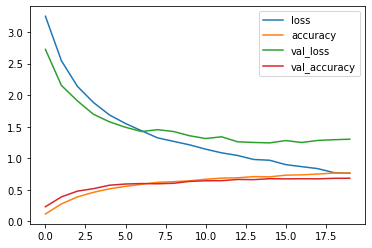

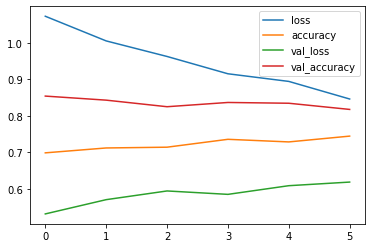

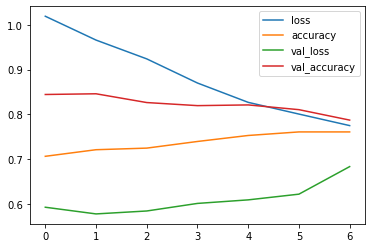

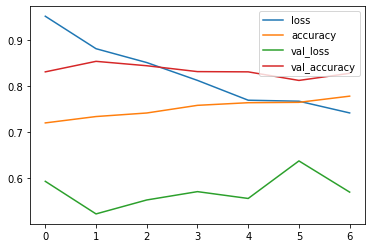

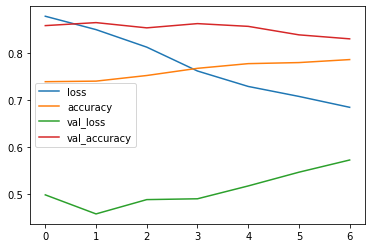

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Input
from sklearn.model_selection import KFold

model_input = Input(shape=(64, 64, 3))
conv_pool_cnn_model = conv_pool_cnn(model_input)
conv_pool_cnn_model.compile(optimizers.Adam(0.001),loss="categorical_crossentropy",metrics=['accuracy'])
conv_pool_cnn_model.summary

datagen=ImageDataGenerator(rescale=1./255.)
class_indices = {}

number_of_splits = 5

kfold_validation = KFold(n_splits= number_of_splits)

for i, (train_split_indexes, test_split_indexes) in enumerate(kfold_validation.split(traindf)):
    train_fold = traindf.iloc[train_split_indexes]
    val_fold = traindf.iloc[test_split_indexes]

    checkpoint = ModelCheckpoint(f'runs\\{PREDICTION_FOLDER}\\best_{i}.h5', monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir=f'runs\\{PREDICTION_FOLDER}\\logs\\fold_{i}', write_graph=True)

    callbacks_list = [checkpoint, early, tb]

    train_generator=datagen.flow_from_dataframe(
        dataframe=train_fold,
        directory="images\\train_no_preprocessing\\",
        x_col="fname",
        y_col="label",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(64,64))

    valid_generator=datagen.flow_from_dataframe(
        dataframe=val_fold,
        directory="images\\train_no_preprocessing\\",
        x_col="fname",
        y_col="label",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(64,64))

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

    conv_pool_cnn_model.fit(train_generator,
                    callbacks=callbacks_list,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50)

    conv_pool_cnn_model.load_weights(f'runs\\{PREDICTION_FOLDER}\\best_{i}.h5')
    
    train_generator.reset()
    valid_generator.reset()
    
    eval_generator=datagen.flow_from_dataframe(
        dataframe=testdf,
        directory="images\\test_no_preprocessing\\",
        x_col="fname",
        y_col= "label",
        batch_size=32,
        seed=42,
        shuffle=False,
        class_mode="categorical",
        target_size=(64,64))

    STEP_SIZE_EVAL=eval_generator.n//eval_generator.batch_size

    eval_generator.reset()
    
    conv_pool_cnn_model.evaluate(eval_generator, steps=STEP_SIZE_EVAL, verbose= 1)
    
    test_generator=datagen.flow_from_dataframe(
        dataframe=testdf,
        directory="images\\test_no_preprocessing\\",
        x_col="fname",
        y_col= None,
        batch_size=32,
        seed=42,
        shuffle=False,
        class_mode= None,
        target_size=(64,64))
    
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    
    test_generator.reset()
    
    pred = conv_pool_cnn_model.predict(test_generator, steps=STEP_SIZE_TEST, verbose= 1)

    np.save(f'runs\\{PREDICTION_FOLDER}\\test_predictions_{i}.npy', pred)
    
    pd.DataFrame(conv_pool_cnn_model.history.history).plot()
    
    #On last step, retrieve actual class_indices, this is used to retrieve the actual string labels
    if i == number_of_splits - 1:
        class_indices = train_generator.class_indices

Time to ensemple our predictions.

In [6]:
from sklearn import metrics

pred_list = []
for i in range(number_of_splits):
    pred_list.append(np.load(f'runs\\{PREDICTION_FOLDER}\\test_predictions_{i}.npy'))

prediction = np.ones_like(pred_list[0])

for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file

predicted_class_indices = np.argmax(prediction,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]

test = pd.read_csv('meta\\test.csv')
test[['fname', 'label']].to_csv(f'runs\\{PREDICTION_FOLDER}\\{PREDICTION_FOLDER}_predictions.csv', index=False)

y_true = test['label']
y_pred = predicted_labels

print(metrics.classification_report(y_true, y_pred, digits=3))

                       precision    recall  f1-score   support

      Acoustic_guitar      0.814     0.778     0.795        45
             Applause      0.857     0.938     0.896        32
                 Bark      0.821     0.821     0.821        28
            Bass_drum      0.900     0.964     0.931        28
Burping_or_eructation      0.938     0.938     0.938        32
                  Bus      0.778     0.560     0.651        25
                Cello      0.830     0.815     0.822        54
                Chime      0.640     0.552     0.593        29
             Clarinet      0.746     0.839     0.790        56
    Computer_keyboard      0.667     0.231     0.343        26
                Cough      0.750     0.800     0.774        30
              Cowbell      0.952     0.952     0.952        42
          Double_bass      0.778     0.875     0.824        40
 Drawer_open_or_close      0.760     0.655     0.704        29
       Electric_piano      0.960     0.750     0.842  